In [24]:
import os, glob
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import itertools
import shutil

In [31]:
replaced_folder = 'DATASETS'

if not os.path.exists(replaced_folder):
    os.mkdir(replaced_folder)

folder = 'NEW_MANUAL'
for fol_singer in os.listdir(folder):
    # print(folder, fol_singer)
    if not os.path.exists(f'{replaced_folder}//{fol_singer}'):
        os.mkdir(f'{replaced_folder}//{fol_singer}')
    for fol_sign in os.listdir(f'{folder}//{fol_singer}'):
        print(folder, fol_singer, fol_sign)
        if not os.path.exists(f'{replaced_folder}//{fol_singer}//{fol_sign}'):
            os.mkdir(f'{replaced_folder}//{fol_singer}//{fol_sign}')
        for file in glob.glob(f'{folder}//{fol_singer}//{fol_sign}//*.npy'):
            # print(folder, fol_singer, fol_sign, file)
            shutil.copyfile(file, f'{replaced_folder}//{fol_singer}//{fol_sign}//{file.split("/")[-1]}')

NEW_MANUAL Aurika1 A
NEW_MANUAL Aurika1 AE
NEW_MANUAL Aurika1 B
NEW_MANUAL Aurika1 C
NEW_MANUAL Aurika1 CH
NEW_MANUAL Aurika1 D
NEW_MANUAL Aurika1 E
NEW_MANUAL Aurika1 E2
NEW_MANUAL Aurika1 G
NEW_MANUAL Aurika1 G2
NEW_MANUAL Aurika1 H
NEW_MANUAL Aurika1 I
NEW_MANUAL Aurika1 I2
NEW_MANUAL Aurika1 K
NEW_MANUAL Aurika1 L
NEW_MANUAL Aurika1 M
NEW_MANUAL Aurika1 MZ
NEW_MANUAL Aurika1 N
NEW_MANUAL Aurika1 NG
NEW_MANUAL Aurika1 O
NEW_MANUAL Aurika1 P
NEW_MANUAL Aurika1 Q
NEW_MANUAL Aurika1 R
NEW_MANUAL Aurika1 S
NEW_MANUAL Aurika1 SH
NEW_MANUAL Aurika1 SH2
NEW_MANUAL Aurika1 T
NEW_MANUAL Aurika1 TV
NEW_MANUAL Aurika1 U2
NEW_MANUAL Aurika1 U3
NEW_MANUAL Aurika1 V
NEW_MANUAL Aurika1 X
NEW_MANUAL Aurika1 Y
NEW_MANUAL Aurika1 Y2
NEW_MANUAL Aurika1 YA
NEW_MANUAL Aurika1 YO
NEW_MANUAL Aurika1 YU
NEW_MANUAL Aurika1 Z
NEW_MANUAL Aurika1 ZH
NEW_MANUAL Aurika2 A
NEW_MANUAL Aurika2 AE
NEW_MANUAL Aurika2 B
NEW_MANUAL Aurika2 C
NEW_MANUAL Aurika2 CH
NEW_MANUAL Aurika2 D
NEW_MANUAL Aurika2 E
NEW_MANUAL Aur

In [27]:
file.split('/')[-1]

'ZH-9.npy'

In [22]:
folder, fol_singer

('NEW_MANUAL', 'SP2')

In [23]:
os.path.exists(folder)

True

In [36]:
npys['A'][0].shape

(90, 1662)

In [2]:
another_indexes = [0, 13, 14, 17, 37, 39, 40, 61, 78, 80, 81, 82, 84, 87, \
                   88, 91, 95, 146, 178, 181, 185, 191, 267, 269, 270, 291, \
                   308, 310, 311, 312, 314, 317, 318, 321, 324, 375, 402, 405, \
                   409, 415]


def get_npys(folder, my_folders):
    npys = dict()
    for fol_singer in os.listdir(folder):
        if fol_singer in my_folders:
            for fol_sign in os.listdir(f'{folder}//{fol_singer}'):
                if os.path.isdir(f'{folder}//{fol_singer}//{fol_sign}'):
                    for file in glob.glob(f'{folder}//{fol_singer}//{fol_sign}//*.npy'):
                        np_arr = np.load(file)
                        if fol_sign in npys.keys():
                            npys[fol_sign].append(np_arr)
                        else:
                            npys[fol_sign] = [np_arr]
    return npys


def get_distance_from_face(npys, pairs=[(17, 0), (291, 61), (181, 39), (405, 269)]):
    final_dist = {}
    for letter in npys.keys():
        final_dist[letter] = []
        for video in npys[letter]:
            distances = []
            for ret in video:
                distance = []
                face_landmarks = ret[33*4:-(21*3*2)].reshape(468, 3)
                for i, j in pairs:
                    distance.append(((face_landmarks[i][0]-face_landmarks[j][0])**2 + \
                                     (face_landmarks[i][1]-face_landmarks[j][1])**2)**0.5)
                distances.append(distance)
            final_dist[letter].append(np.array(distances))
    return final_dist


def get_distance_with_first_appear(npys, a=10, b=20, 
                                   pairs=[(17, 0), (291, 61), (181, 39), (405, 269)], whole_coord=False):
    final_dist = {}
    for letter in npys.keys():
        final_dist[letter] = []
        for video in npys[letter]:
            distances = []
            for i in range(video.shape[0]):
                if np.any(video[i][-21*3*2:]):
                    break
            for ret in video[i-a:i+b]:
                distance = []
                face_landmarks = ret[33*4:-(21*3*2)].reshape(468, 3)
                if whole_coord:
                    for i in another_indexes:
                        for j in face_landmarks[i]:
                            distance.append(j)
                else:
                    for i, j in pairs:
                        distance.append(((face_landmarks[i][0]-face_landmarks[j][0])**2 + \
                                         (face_landmarks[i][1]-face_landmarks[j][1])**2)**0.5)
                
                distances.append(distance)
            final_dist[letter].append(np.array(distances))
    return final_dist


def get_tsl_dtw(X_train, n_clusters=4, metric='Euclidean', verbose=False, seed=42):
    X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
    sz = X_train.shape[1]
    
    print(f"{metric} k-means")
    if metric == 'Euclidean':
        km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=verbose, random_state=seed, n_jobs=-1)
    elif metric == 'dtw':
        km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=seed, verbose=verbose, n_jobs=-1) # max_iter=10,
    elif metric == "softdtw":
        km = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", metric_params={"gamma": .01},
                              verbose=verbose, random_state=seed, n_jobs=-1)
    else:
        km = KShape(n_clusters=n_clusters, verbose=verbose, random_state=seed)
    
    y_pred = km.fit_predict(X_train)
    
    plt.figure(figsize=(16, 4))
    for yi in range(n_clusters):
        plt.subplot(1, n_clusters, yi + 1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(km.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        # plt.ylim(-0.05, 0.15)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
        if yi == 1:
            plt.title(f"{metric} $k$-means")
    return y_pred, km

In [3]:
print('VIDEOS', os.listdir('VIDEOS'))
print('NEW_MANUAL', os.listdir('NEW_MANUAL'))

VIDEOS ['speaker_1_woman', 'speaker_2_man', 'speaker_3_woman', 'Nazerke1', 'Nazerke2', 'Avrika']
NEW_MANUAL ['Aurika1', 'Aurika2', 'Nazerke1', 'Nazerke2', 'SP2']


In [4]:
# npys = get_npys('VIDEOS', ['Nazerke1', 'Nazerke2', 'Avrika'])
my_folders = ['Aurika2', 'Nazerke1', 'Nazerke2']
# my_folders = ['Aurika2']
# my_folders = ['Nazerke1', 'Nazerke2']
npys = get_npys('NEW_MANUAL', my_folders)
a = 10
b = 20

# final_dist_no_process = get_distance_with_first_appear(npys, a=a, b=b, whole_coord=True)
final_dist_no_process = get_distance_with_first_appear(npys, a=a, b=b, whole_coord=False)

In [5]:
class_1 = ['A', 'AE', 'YA']
class_2 = ['B', 'P', 'P2', 'F', 'V', 'M']
class_3 = ['O', 'U', 'U2', 'U3', 'O2', 'YO', 'YU']
class_4 = ['CH', 'E2', 'G2', 'H', 'NG', 'R', 'SH2', 'Y2', 'ZH']
class_5 = ['C', 'D', 'E', 'G', 'I', 'K', 'L', 'N', 'Q', 'S', 'SH', 'T', 'X', 'Y', 'Z']
out_lcass = ['I2', 'MZ', 'TV']

In [6]:
# 0:   'A', 'AE', 'YA'
# 1:   'B', 'P', 'P2', 'F', 'V', 'M'
# 2:   'O', 'U', 'U2', 'U3', 'O2', 'YO', 'YU'
# 3:   'CH', 'E2', 'G2', 'H', 'NG', 'R', 'SH2', 'Y2', 'ZH'


In [7]:
final_dist = final_dist_no_process.copy()
for i in out_lcass:
# for i in out_lcass+class_4+class_2+class_3:
    try:
        del final_dist[i]
    except:
        print('error', i)
final_dist.keys()

dict_keys(['A', 'AE', 'B', 'C', 'CH', 'D', 'E', 'E2', 'F', 'G', 'G2', 'H', 'I', 'K', 'L', 'M', 'N', 'NG', 'O', 'O2', 'P', 'P2', 'Q', 'R', 'S', 'SH', 'T', 'U', 'U2', 'U3', 'V', 'X', 'Y', 'Y2', 'YA', 'YO', 'YU', 'Z', 'ZH', 'SH2'])

In [8]:
X = []
y = []

letter_list = {v: k for k, v in enumerate(list(final_dist.keys()))}
letter_list_2 = {k: v for k, v in enumerate(list(final_dist.keys()))}

for letter in final_dist.keys():
    for j in range(len(final_dist[letter])):
        if len(final_dist[letter][j]) == a+b:
            # X.append(pd.DataFrame(final_dist[letter][j]).iloc[:, 0].to_numpy().reshape(-1, 1))
            # X.append(pd.DataFrame(final_dist[letter][j]).iloc[:,[0, 3]].to_numpy())
            X.append(pd.DataFrame(final_dist[letter][j]).iloc[:,].to_numpy())
            # X.append((pd.DataFrame(final_dist[letter][j])[3]/pd.DataFrame(final_dist[letter][j])[0]).to_numpy().reshape(-1, 1))
            
            # y.append(letter_list[letter])
            # class_1 = ['A', 'AE', 'YA']
            # class_2 = ['B', 'P', 'P2', 'F', 'V', 'M']
            # class_3 = ['O', 'U', 'U2', 'U3', 'O2', 'YO', 'YU']
            if letter in class_1:
                y.append(0)
            elif letter in class_2:
                y.append(1)
            elif letter in class_3:
                y.append(2)
            elif letter in class_4:
                y.append(3)
            elif letter in class_5:
                y.append(4)

y = np.array(y)
X = np.array(X)

In [9]:
X = X.reshape((X.shape[0], -1))

In [10]:
y.shape

(1422,)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(1066, 120)
(356, 120)
(1066,)


In [12]:
def plot_confusion_matrix(cm, classes, normalize=False, name='lstm_conf'):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # print(cm)
    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=20)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.savefig(f'{name}.png')

              precision    recall  f1-score   support

           0       0.68      0.63      0.65        27
           1       0.67      0.54      0.60        48
           2       0.79      0.80      0.80        66
           3       0.40      0.44      0.42        79
           4       0.64      0.65      0.64       136

    accuracy                           0.62       356
   macro avg       0.64      0.61      0.62       356
weighted avg       0.62      0.62      0.62       356



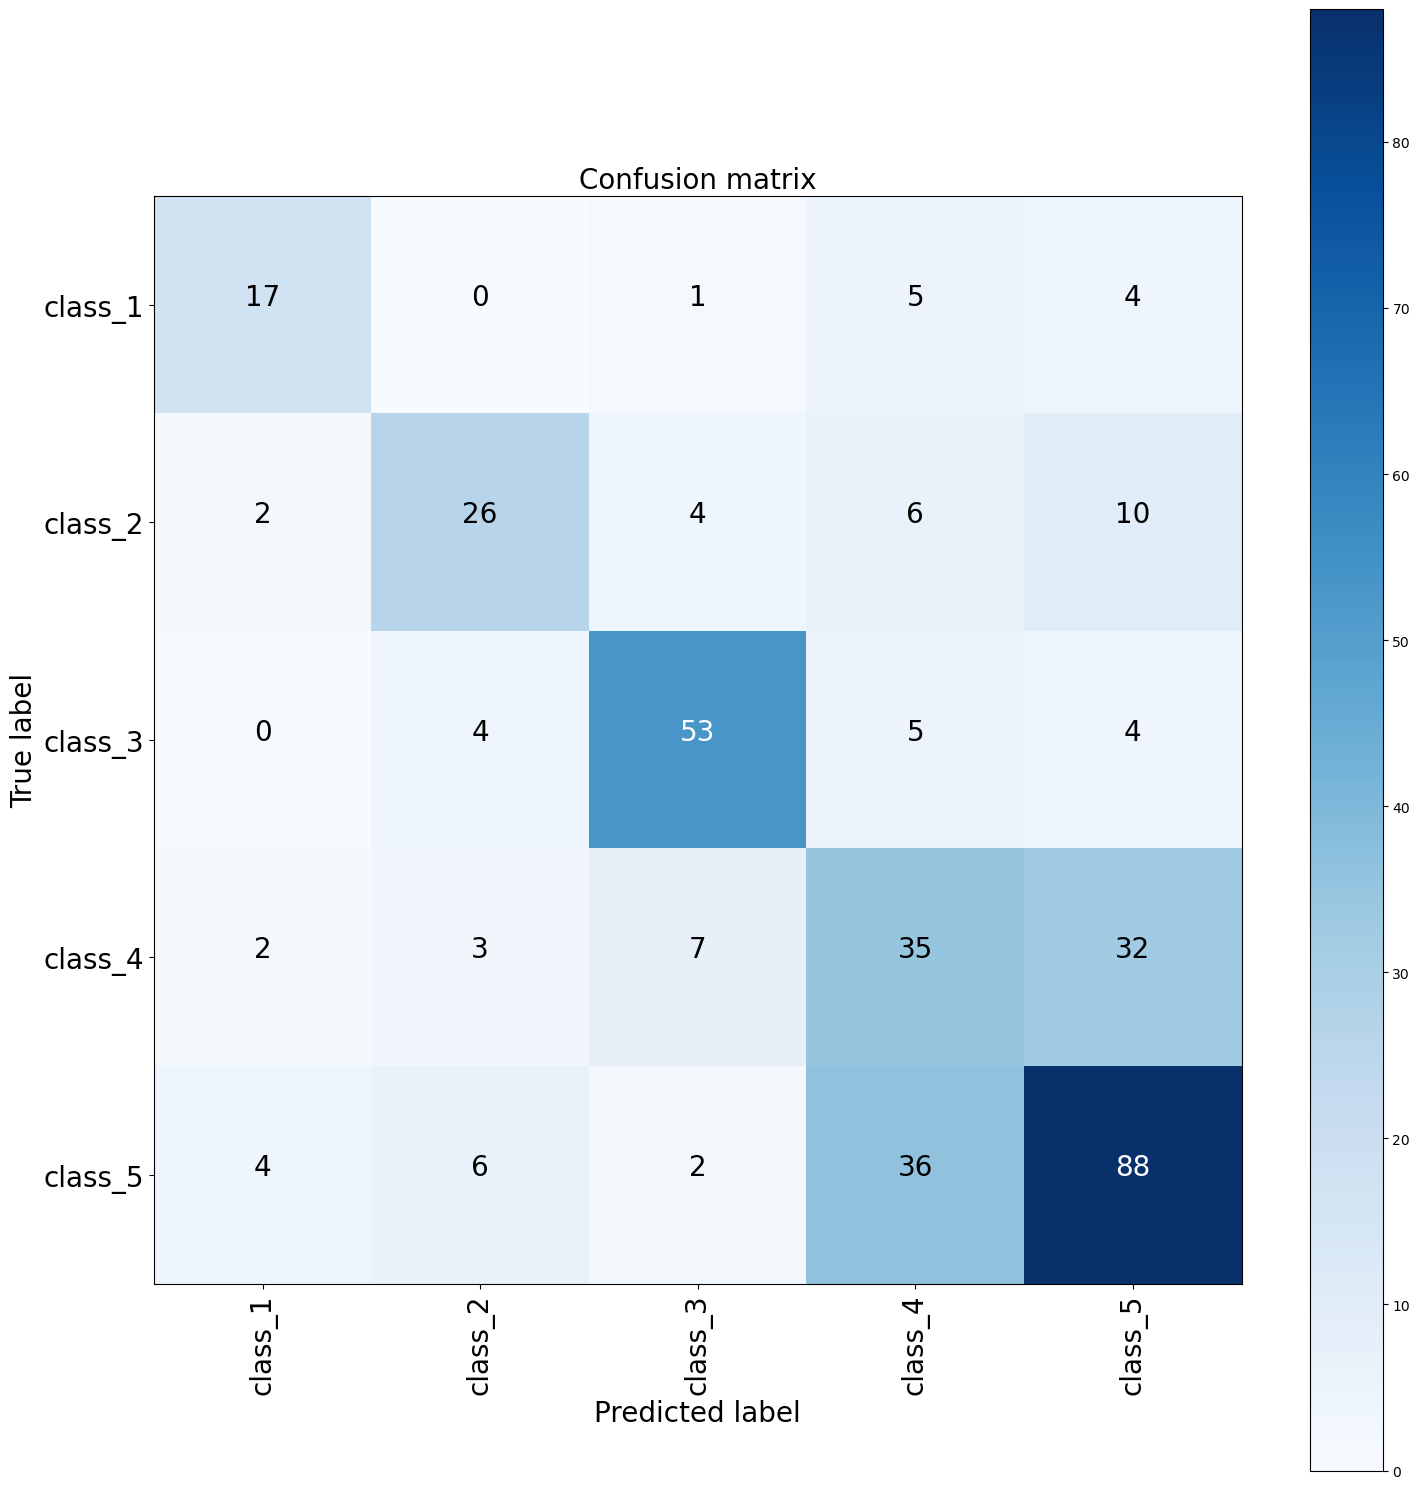

In [13]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
print(classification_report(y_test, y_pred_dt))

# confusion_matrix(y_test, y_pred_dt)
plot_confusion_matrix(confusion_matrix(y_test, y_pred_dt),
                      classes=[f'class_{i}' for i in range(1, 6)], name='cnn_conf')

In [14]:
# rf = RandomForestClassifier(max_depth=10, n_estimators=400)
# rf.fit(X_train, y_train)

# y_pred_rf = rf.predict(X_test)
# print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.75      0.44      0.56        27
           1       0.90      0.77      0.83        48
           2       0.90      0.95      0.93        66
           3       0.54      0.56      0.55        79
           4       0.72      0.79      0.75       136

    accuracy                           0.74       356
   macro avg       0.76      0.70      0.72       356
weighted avg       0.74      0.74      0.74       356



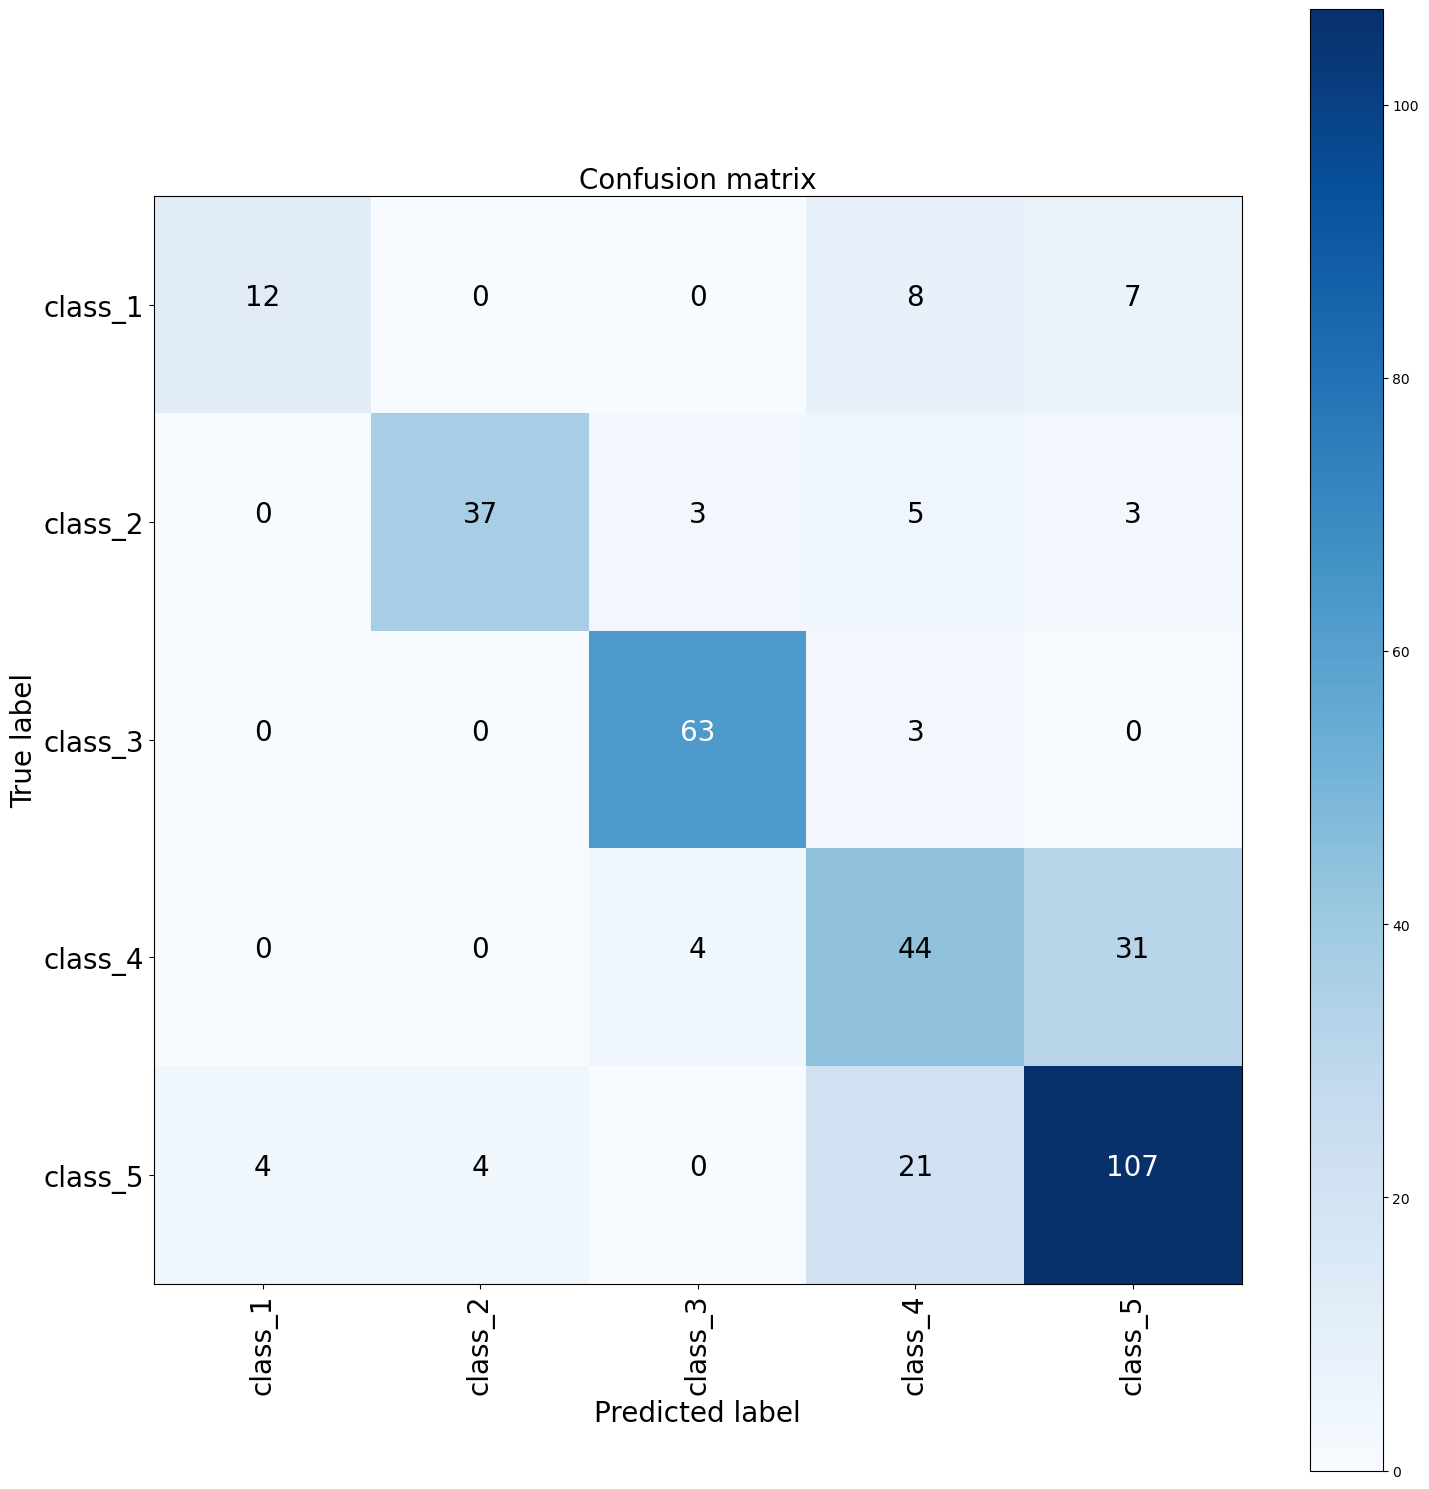

In [15]:
xgbc = XGBClassifier(n_estimators= 200, max_depth=10, gamma=0.1, booster='gbtree', n_jobs=10)
xgbc.fit(X_train, y_train)

y_pred_xgbc = xgbc.predict(X_test)
print(classification_report(y_test, y_pred_xgbc))

# print(confusion_matrix(y_test, y_pred_xgbc))
plot_confusion_matrix(confusion_matrix(y_test, y_pred_xgbc),
                      classes=[f'class_{i}' for i in range(1, 6)], name='cnn_conf')

In [ ]:
#                 precision    recall  f1-score   support
#            0       0.75      0.44      0.56        27
#            1       0.90      0.77      0.83        48
#            2       0.90      0.95      0.93        66
#            3       0.54      0.56      0.55        79
#            4       0.72      0.79      0.75       136
#     accuracy                           0.74       356
#    macro avg       0.76      0.70      0.72       356
# weighted avg       0.74      0.74      0.74       356

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}
              precision    recall  f1-score   support

           0       0.81      0.48      0.60        27
           1       0.90      0.73      0.80        48
           2       0.87      0.92      0.90        66
           3       0.60      0.51      0.55        79
           4       0.72      0.87      0.79       136

    accuracy                           0.75       356
   macro avg       0.78      0.70      0.73       356
weighted avg       0.75      0.75      0.74       356



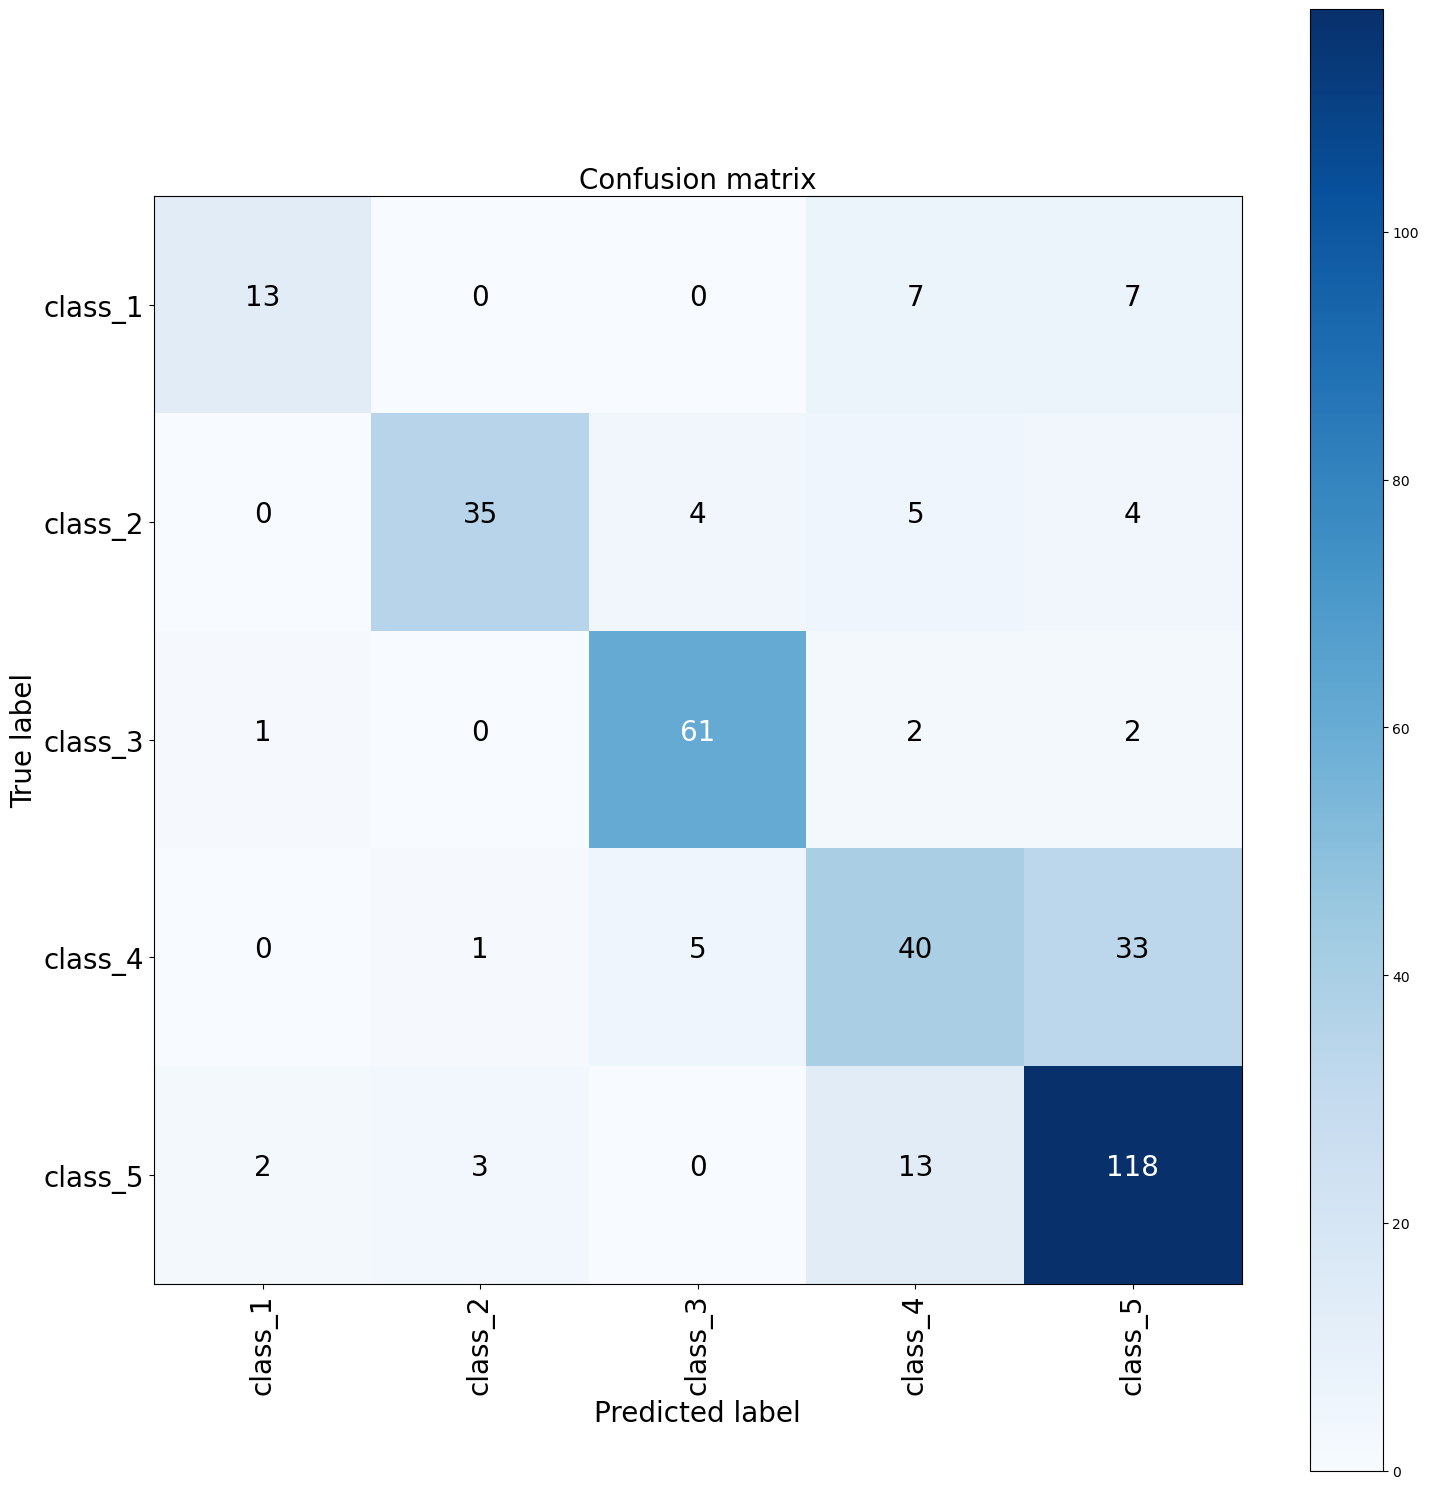

[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   4.1s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   3.0s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   3.6s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.9s
[CV] END criterion=gini, max_depth=None, min

In [16]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(), 
    param_grid=param_grid,
    cv=5,
    scoring='accuracy', 
    verbose=2, 
    n_jobs=20
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

y_pred_rf = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

plot_confusion_matrix(confusion_matrix(y_test, y_pred_rf),
                      classes=[f'class_{i}' for i in range(1, 6)], name='cnn_conf')

In [86]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}
grid_search = GridSearchCV(estimator=XGBClassifier(n_jobs=None), param_grid=param_grid,
                           cv=5, scoring='accuracy', verbose=2, n_jobs=10)

grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

y_pred_xgbc = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgbc))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


KeyboardInterrupt: 

In [60]:
import psutil

total_cpus = psutil.cpu_count()
cpu_percentages = psutil.cpu_percent(interval=1, percpu=True)
busy_cpus = sum(1 for percent in cpu_percentages if percent > 0)

print(f"Общее количество процессоров: {total_cpus}")
print(f"Количество занятых процессоров: {busy_cpus}")
# print(f"Процент загрузки процессоров: {cpu_percentages}")

Общее количество процессоров: 160
Количество занятых процессоров: 16


In [ ]:
# new class 

# [ 'CH', 'E2', 'G2', 'H', 'NG', 'R', 'SH2', 'Y2', 'ZH'] 
# ['C', 'D', 'E', 'G', 'I', 'K', 'L', 'N', 'Q', 'S', 'SH', 'T', 'X', 'Y', 'Z']

# qaz variant
# [ ч, э, ғ, һ, ң, р, щ, і, ж] 
# [ц, д, е, г, и, к, л, н, қ, с, ш, т, х, ы, з]

In [23]:
#